# Activité - Implémentez une validation croisée

## Code de la classe de validation croisée Sklearn

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors, metrics

class VerificationCroiseeSKearn:
    
    def __init__(self,path):
        self.data = pd.read_csv(path, sep=";")        

    def renvoyer_Meilleur_Score(self):
        X = self.data.as_matrix(self.data.columns[:-1])
        y = self.data.as_matrix([self.data.columns[-1]])
        
        y = y.flatten()
        
        y_class = np.where(y<6, 0, 1)
        
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                                                            X,
                                                                            y_class,
                                                                            test_size=0.3)
        
        std_scale = preprocessing.StandardScaler().fit(X_train)
        X_train_std = std_scale.transform(X_train)
        stdt_scale = preprocessing.StandardScaler().fit(X_test)
        X_test_std = stdt_scale.transform(X_test)
        
        # Fixer les valeurs des hyperparamètres à tester
        param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
        # Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
        score = 'accuracy'
        # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # un classifieur kNN
                                           param_grid, # hyperparamètres à tester
                                           cv=5, # nombre de folds de validation croisée
                                           scoring=score # score à optimiser
                                           )
                
        # Optimiser ce classifieur sur le jeu d'entraînement
        clf.fit(X_train_std, y_train)
        # Afficher le(s) hyperparamètre(s) optimaux
        print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:{}".format(clf.best_params_))
        # Afficher les performances correspondantes
        print('------------------------------------')
        print("Résultats de la validation croisée :")
        
        for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                                     clf.cv_results_['std_test_score'], # écart-type du score
                                     clf.cv_results_['params'] # valeur de l'hyperparamètre
                                     ):
            
            print("Paramètres {} : Score moyen = {} - intervalle erreur : {}".format(
                                params, # hyperparamètre
                                round(mean,4), # score moyen
                                round(std * 2,4), # barre d'erreur
                                ))
        
        y_pred = clf.predict(X_test_std)
        print("\nLe meilleur score obtenu est le suivant : %0.4f" % metrics.accuracy_score(y_test, y_pred))
        
        return clf

## Code de notre classe personnalisée de validation croisée

In [2]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics

class ValidationCroisee:
    
    def __init__(self,cheminFichier,nombreFold,hyperParametre):  
        """Initialisation de l'objet validation croisée de classification K-neighbors"""              
        self.ensembleFold = []
        self.nombreFolds = nombreFold
        self.hyperParametres = []
        self.modele = neighbors.KNeighborsClassifier()
        
        self.data = pd.read_csv(cheminFichier, sep=";") 
        self.Decoupage_Fold(self.returnData(),nombreFold)  
        self.initialisationParametres(hyperParametre)

    def initialisationParametres(self,hyperParametre):
        """Initialisation des hyperparamètres possibles au format de l'objet de classification"""
        for parametre in hyperParametre:
            for parametreValeur in hyperParametre[parametre]:
                valeur = parametre + "=" + str(parametreValeur)
                self.hyperParametres.append(valeur) 
        
        self.resultat = pd.DataFrame(np.zeros(len(self.hyperParametres)),
                                     index=self.hyperParametres,
                                     columns=['Erreur'])
        
    def returnData(self):
        """Retourne les données brutes passées en paramètre à la création de la classe"""
        return self.data

    def returnFeatures(self,donnees):
        """Renvoie les varaibles explicatives d'un dataset passé en paramètre"""
        raw_data = donnees[:,:-1]
        data_scale = preprocessing.StandardScaler().fit(raw_data)
        return data_scale.transform(raw_data)
             
    def returnClassification(self,donnees):
        """Renvoie la variable expliquée d'un dataset passé en paramètre"""
        data = donnees[:,-1] 
        y_class = np.where(data<6, 0, 1)
        y = np.asarray(y_class.reshape(-1,1))
        return y.squeeze()
    
    def returnEnsembleFold(self):
        """Retourne l'ensemble des jeux de données partagés en K-fold"""
        return self.ensembleFold

    def returnSetTraining(self):
        """Renvoie les K-fold dévolus à l'apprentissage des données"""
        return self.SetTraining
    
    def returnSetTest(self):
        """Renvoie les K-fold dévolus au test des données"""
        return self.SetTest
    
    def returnClassificationTraining(self):
        """Renvoie les variables expliquées des K-fold dévolus à l'apprentissage des données"""
        return self.returnClassification(self.returnSetTraining())
    
    def returnClassificationTest(self):
        """Renvoie les variables expliquées des K-fold dévolus au test des données"""
        return self.returnClassification(self.returnSetTest())
 
    def returnFeaturesTraining(self):
        """Renvoie les variables explicatives des K-fold dévolus à l'apprentissage des données"""
        return self.returnFeatures(self.returnSetTraining())
    
    def returnFeaturesTest(self):
        """Renvoie les variables explicatives des K-fold dévolus au test des données"""
        return self.returnFeatures(self.returnSetTest())
    
    def Decoupage_Fold(self,Dataset,nombre_Folds):
        """ Découpe le jeu de données complet en un nombre pré-défini de K-folds non stratifiés"""
        nombreIndividus = Dataset.shape[0]
        Taille_Fold = int(nombreIndividus / nombre_Folds) + 1
        debutFold = 0
        finFold = 0
        
        for numeroFold in range(0,nombre_Folds) :
            debutFold = numeroFold * Taille_Fold
            finFold = min((numeroFold+1) * Taille_Fold,nombreIndividus)
            self.ensembleFold.append(Dataset.iloc[debutFold:finFold,:])

    def CombinaisonFold(self,numeroFoldTest):
        """ Renvoie la combinatoire des numéros de K-fold dévolus au test et à l'apprentissage"""
        combinaisonFold = []
        for indice in range(0,self.nombreFolds):
            if indice!=numeroFoldTest:
                combinaisonFold.append(indice)
        return combinaisonFold
    
    def Separation_Test_Training(self,numeroFoldTest):
        """ Sépare le jeu de données en folds d'apprentissage et folds de test"""
        combinaisonFold = self.CombinaisonFold(numeroFoldTest)
        self.SetTraining = np.matrix(self.returnEnsembleFold()[combinaisonFold[-1]])
        combinaisonFold.pop()
        
        for numero_fold in combinaisonFold:
            self.SetTraining = np.vstack([self.SetTraining,self.ensembleFold[numero_fold]])
        
        self.SetTest = np.matrix(self.ensembleFold[numeroFoldTest])

    def decomposition_Parametres(self,parametres):     
        """ Transforme le libellé des hyperparamètres en dictionnaire de paramètres"""
        params = {}
        param= parametres[:parametres.find('=')]
        params[param]=int(parametres[-1])
        return params

    def entrainement_Modele(self,hyperParametres):
        """Entraine le modèle sur toutes les combinaisons de K-folds selon des hyperparamètres fixés"""
        self.erreur = []
        classification = neighbors.KNeighborsClassifier()
        classification.set_params(**self.decomposition_Parametres(hyperParametres))
        
        for numeroFoldTest in range(0,self.nombreFolds):            
            self.Separation_Test_Training(numeroFoldTest)            
            classification.fit(self.returnFeaturesTraining(),
                               self.returnClassificationTraining())
            
            self.calcul_Erreur_Modele(
                                        classification.predict(
                                                                self.returnFeaturesTest()))         
            
        self.modele = classification
                                
        return (np.array(self.erreur)).mean()
                        
    def calcul_Erreur_Modele(self,prediction):
        """Calcul l'erreur du modèle en comparant prédiction du modèle et données de test"""
        valeurs_reelles = self.returnClassificationTest()
        delta = np.where((valeurs_reelles - prediction)==0,0,1)
        erreur_moyenne = delta.mean()
        self.erreur.append(erreur_moyenne)
        return (np.array(self.erreur)).mean()

    def evaluation_HyperParametres(self):
        """Performe l'ensemble des évaluations du modèle pour chaque combinaison d'hyperparamètres"""
        for hyper_parametres in self.hyperParametres:
            self.resultat.loc[hyper_parametres] = self.entrainement_Modele(hyper_parametres)
        
        self.resultat['Score'] = 1 - self.resultat['Erreur']
        print(self.resultat)
        
        return self.renvoyer_Meilleur_Modele()

    def renvoyer_Meilleur_Parametre(self):
        """Renvoie les hyperparamètres permettant d'obtenir le meilleur score de classification"""
        return self.resultat.idxmin()[0]
        
    def renvoyer_Meilleur_Score(self):
        """Renvoie le meilleur score obtenu après exécution de toutes les combinaisons d'hyperparamètres"""
        meilleurScore = 1 - self.resultat.loc[self.renvoyer_Meilleur_Parametre()][0]
        return round(meilleurScore,4)                    
        
    def renvoyer_Meilleur_Modele(self):
        """Renvoie l'objet du modèle de classification entraîné ayant le meilleur score"""
        self.entrainement_Modele(self.resultat.idxmin()[0])
        
        return self.modele


## Comparaison des 2 classes de validation croisée

In [6]:
# Importation des deux classes de classification par validation croisée
# from Voisins_KNN_Sklearn import VerificationCroiseeSKearn
# from Voisins_KNN_Validation_croisee import ValidationCroisee

"""Afin d'avoir les mêmes données de référence, nous n'aurons pas recours à la bibliothèque Sklearn-Model """
""" Nous utiliserons deux fichiers de test et d'apprentissage que nous avons découpés en amont"""
""" Le decoupage entre données d'apprentissage et de test s'est fait selon un ratio de 80%-20%"""

# Configuration des paramètres
filePath = 'winequality-white-Training.csv'
nombre_Folds = 5
hyperparametres = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}


## Classification avec la bibliothèque Sklearn

In [7]:
# Classification avec la bibliothèque Sklearn
print('--------------------------------------------------------------------------------')
print('------- Validation croisée avec la bibliothèque Sklearn-------------------------')
print('--------------------------------------------------------------------------------')
validation_SK = VerificationCroiseeSKearn(filePath)
Classifieur_SKLearn = validation_SK.renvoyer_Meilleur_Score()
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
------- Validation croisée avec la bibliothèque Sklearn-------------------------
--------------------------------------------------------------------------------
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:{'n_neighbors': 11}
------------------------------------
Résultats de la validation croisée :
Paramètres {'n_neighbors': 3} : Score moyen = 0.7431 - intervalle erreur : 0.026
Paramètres {'n_neighbors': 5} : Score moyen = 0.7403 - intervalle erreur : 0.0184
Paramètres {'n_neighbors': 7} : Score moyen = 0.7513 - intervalle erreur : 0.0195
Paramètres {'n_neighbors': 9} : Score moyen = 0.7496 - intervalle erreur : 0.0113
Paramètres {'n_neighbors': 11} : Score moyen = 0.7567 - intervalle erreur : 0.0298
Paramètres {'n_neighbors': 13} : Score moyen = 0.7567 - intervalle erreur : 0.0191
Paramètres {'n_neighbors': 15} : Score moyen = 0.7567 - intervalle erreur : 0.0214

Le meilleur score obtenu est l

## Classification avec la bibliothèque personnalisée

In [8]:

# Classification avec notre propre bibliothèque de validation croisée de classification
print('--------------------------------------------------------------------------------')
print('------- Validation croisée avec notre propre bibliothèque ----------------------')
print('--------------------------------------------------------------------------------')
validation_Custom = ValidationCroisee(filePath,5,hyperparametres)
Classifieur_Custom = validation_Custom.evaluation_HyperParametres()
print('--------------------------------------------------------------------------------')
print('Les hyper-paramètres donnant le meilleur score sont les suivants : {}'.format(validation_Custom.renvoyer_Meilleur_Parametre()))
print('--------------------------------------------------------------------------------')
print('Le meilleur score obtenu après validation croisée des K-folds et hyperparamètres est le suivant : {}'.format(validation_Custom.renvoyer_Meilleur_Score()))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
------- Validation croisée avec notre propre bibliothèque ----------------------
--------------------------------------------------------------------------------
                  Erreur     Score
n_neighbors=3   0.292559  0.707441
n_neighbors=5   0.280801  0.719199
n_neighbors=7   0.277302  0.722698
n_neighbors=9   0.267300  0.732700
n_neighbors=11  0.307812  0.692188
n_neighbors=13  0.292559  0.707441
n_neighbors=15  0.280801  0.719199
--------------------------------------------------------------------------------
Les hyper-paramètres donnant le meilleur score sont les suivants : n_neighbors=9
--------------------------------------------------------------------------------
Le meilleur score obtenu après validation croisée des K-folds et hyperparamètres est le suivant : 0.7327
--------------------------------------------------------------------------------


#### On obtient des scores relativement proches de 73% pour les deux validations croisées. On remarquera néanmoins, que l'on obtient pas rigoureusement le même résultat et surtout que l'hyperparamètre proposé n'est pas le même (nombre de voisin respectivement à n=9 et n=11). 

#### Cela est dû au fait que la validation de Sklearn utilise la stratification pour répartir au hasard les proportions de positifs et de négatifs (méthode model_selection.StratifiedKFold) alors que pour notre validation customisée on a recours à une méthode statique  de type model_selection.KFold où les éléments ne sont pas randomisés (et ce pour pouvoir faciliter les comparaisons entre Folds).

## Comparaison des prédictions avec les 2 types de validation croisée

In [10]:
# Importation des données de test 
data = pd.read_csv('E:\Data\RawData\ClassificationVin\winequality-white-Test.csv', sep=";")

# Séparation des Features et des données de Classification 
X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])

# Binarisation des données de classification
y = y.flatten()
y_test = np.where(y<6, 0, 1)

In [11]:
# Prédiction avec la bibliothèque Sklearn
print('--------------------------------------------------------------------------------')
print('--------------- Prédiction avec la bibliothèque Sklearn-------------------------')
print('--------------------------------------------------------------------------------')
y_pred = Classifieur_SKLearn.predict(X)
score_predicition = metrics.accuracy_score(y_test, y_pred)
print("La qualité de prédiction est la suivanta : %0.4f" % score_predicition)
print('--------------------------------------------------------------------------------')


--------------------------------------------------------------------------------
--------------- Prédiction avec la bibliothèque Sklearn-------------------------
--------------------------------------------------------------------------------
La qualité de prédiction est la suivanta : 0.2948
--------------------------------------------------------------------------------


In [12]:
# Prédiction avec notre propre bibliothèque de validation croisée de classification
print('--------------------------------------------------------------------------------')
print('------- Validation croisée avec notre propre bibliothèque ----------------------')
print('--------------------------------------------------------------------------------')
y_pred = Classifieur_Custom.predict(X)
score_predicition = metrics.accuracy_score(y_test, y_pred)
print("La qualité de prédiction est la suivanta : %0.4f" % score_predicition)
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
------- Validation croisée avec notre propre bibliothèque ----------------------
--------------------------------------------------------------------------------
La qualité de prédiction est la suivanta : 0.2948
--------------------------------------------------------------------------------


### On retrouve bien des scores identiques de prédiction sur des jeux de données non randomisés...

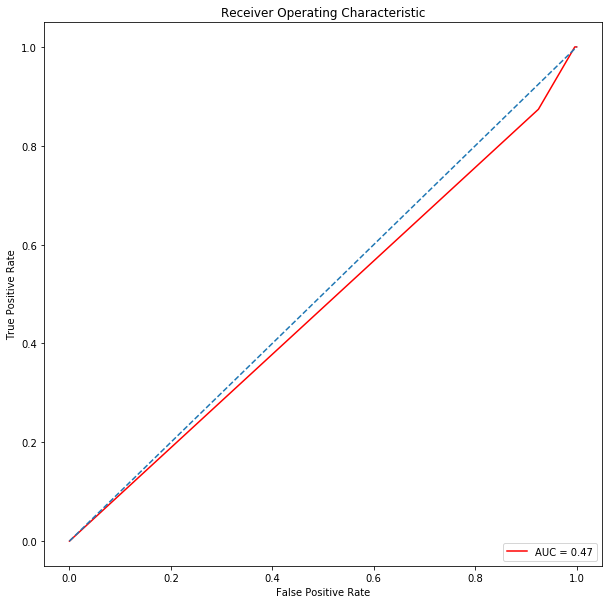

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Représentation des résultats de prédiction à l'aide d'une courbe ROC
# Calcul des prédictions sous forme probabilisée 
y_prob = Classifieur_Custom.predict_proba(X)[:,1] 

# Calcul des faux et vrais positifs
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Affichage de la courve ROC        
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### On constate que la qualité de prédiction est très médiocre, ce qui s'explique par le fait que nous avons arbitrairement séparé notre dataset entre données d'apprentissage et de test sans aucune action de randomisation, ce qui a provoqué des biais entre les deux jeux de données, générant un classifieur overfitté...

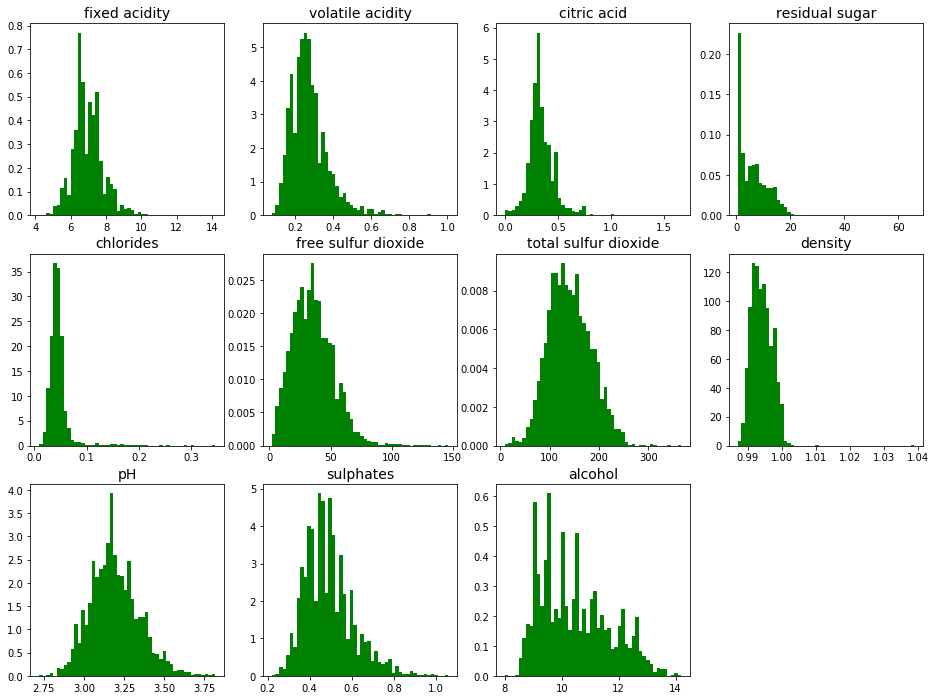

In [14]:
# Affichage des histogrammes des sets de données
# Jeu de données d'apprentissage
data = pd.read_csv('winequality-white-Training.csv', sep=";")

Training = data.as_matrix(data.columns[:-1])

fig = plt.figure(figsize=(16, 12))

for feat_idx in range(Training.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(Training[:, feat_idx],
                bins=50, 
                color='green',
                density=True, 
                edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)


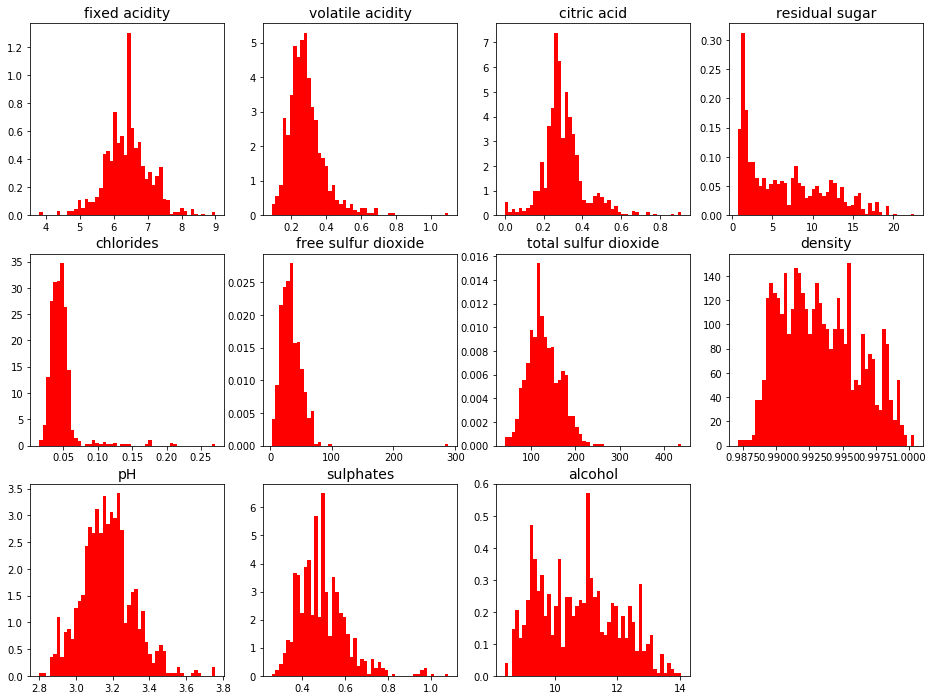

In [15]:
# Affichage des histogrammes des sets de données
# Jeu de données de test
data = pd.read_csv('winequality-white-Test.csv', sep=";")

Test = data.as_matrix(data.columns[:-1])

fig = plt.figure(figsize=(16, 12))

for feat_idx in range(Test.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(Test[:, feat_idx],
                bins=50, 
                color='red',
                density=True, 
                edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

### On constate bien par exemple que sur le critère "fixed acidity", les données sont plutôt décentrées vers la gauche sur le jeu de données d'apprentissage, alors qu'elles sont plutôt centrées autours de la moyenne sur le jeu de données de test. C'est pourquoi, ces biais génèrent un sur-apprentissage du classifieur qui ne permet pas de faire de bonnes prédictions sur les données à tester... Il aurait donc fallu utiliser les fonctions de randomisation de la bibliothèque Sklearn, mais cela aurait rendu plus compliqué une comparaison obtenue entre les 2 méthodes, puisque la comparaison ne se serait pas faite à périmètres de données constant... 